In [2]:
!pip install pycocotools

  Using cached contourpy-1.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.53.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (162 kB)
  Using cached kiwisolver-1.4.5-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 59.5 MB/s eta 0:00:0000:0100:01
Using cached contourpy-1.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (305 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.53.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.6 MB)
Using cached kiwisolver-1.4.5-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
Using cached pyparsing-3.1.2-p

In [2]:
!wget http://images.cocodataset.org/zips/train2017.zip

--2024-08-18 15:00:41--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.102.49, 52.217.142.161, 3.5.25.125, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.102.49|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip        11%[=>                  ]   2.16G  6.34MB/s    eta 60m 38s^C


In [98]:
from torchvision import datasets, transforms
import torch
from pathlib import Path
from PIL import Image
# การแปลงรูปภาพและการโหลดข้อมูล
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        #. Load data from Path no Label
        self.data = [f for f in Path('train2017').iterdir()]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.transform(Image.open(self.data[idx]).convert('RGB'))
            

dataset = CustomDataset(transform=transform)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)

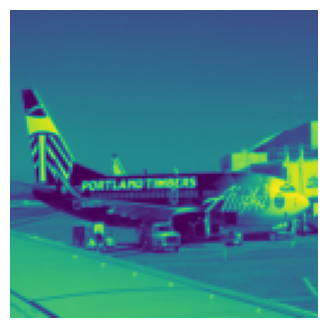

In [83]:
import matplotlib.pyplot as plt
Img = next(iter(dataloader))[0]
plt.figure(figsize=(4, 4))
plt.axis("off")
plt.imshow((Img[0] + 1) / 2)
plt.show()

In [81]:
path = "train2017/000000228474.jpg"
img = Image.open(path).convert('RGB')
img = transform(img)
img.shape

torch.Size([3, 128, 128])

In [90]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim, text_dim, img_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + text_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, img_dim),
            nn.Tanh()
        )

    def forward(self, z, text_embedding):
        gen_input = torch.cat((z, text_embedding), dim=1)
        img = self.model(gen_input)
        return img

class Discriminator(nn.Module):
    def __init__(self, img_dim, text_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim + text_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, text_embedding):
        disc_input = torch.cat((img, text_embedding), dim=1)
        validity = self.model(disc_input)
        return validity


In [96]:
latent_dim = 100
text_dim = 50  # ขนาดของการฝังข้อความ (text embedding)
img_dim = 512 * 512 * 3
num_epochs = 200

# การสร้างโมเดล
generator = Generator(latent_dim, text_dim, img_dim).to("cuda")
discriminator = Discriminator(img_dim, text_dim).to("cuda")

In [99]:
import torch.optim as optim
from tqdm.auto import tqdm
# การกำหนด optimizer
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

adversarial_loss = nn.BCELoss()

for epoch in range(num_epochs):
    for i, imgs in enumerate(tqdm(dataloader)):
        # สร้าง label จริงและปลอม
        imgs = imgs.to("cuda")
        valid = torch.ones(imgs.size(0), 1, requires_grad=False).to("cuda")
        fake = torch.zeros(imgs.size(0), 1, requires_grad=False).to("cuda")

        # สร้าง latent space และข้อความ
        z = torch.randn(imgs.size(0), latent_dim).to("cuda")
        text_embedding = torch.randn(imgs.size(0), text_dim).to("cuda")  # สมมุติว่าเราใช้ random embedding

        # สร้างรูปปลอม
        gen_imgs = generator(z, text_embedding)

        # ฝึก Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(imgs.view(imgs.size(0), -1), text_embedding), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), text_embedding), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # ฝึก Generator
        optimizer_G.zero_grad()
        g_loss = adversarial_loss(discriminator(gen_imgs, text_embedding), valid)
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch {epoch}/{num_epochs} - Loss D: {d_loss.item()}, loss G: {g_loss.item()}")


100%|██████████| 116/116 [13:21<00:00,  6.91s/it]


Epoch 0/200 - Loss D: 0.39586079120635986, loss G: 0.8860207200050354


 41%|████      | 47/116 [05:22<07:54,  6.87s/it]


KeyboardInterrupt: 

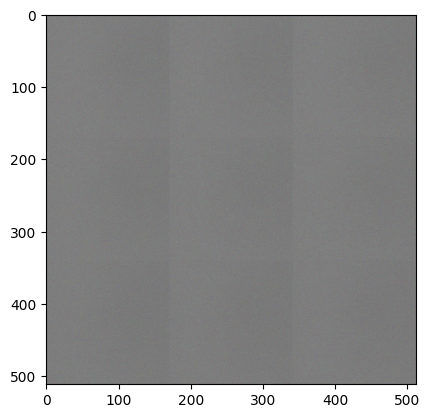

In [102]:
z = torch.randn(1, latent_dim).to("cuda")  # สร้าง latent space สำหรับรูปภาพใหม่
text_embedding = torch.randn(1, text_dim).to("cuda")  # ข้อความใหม่
gen_img = generator(z, text_embedding).view(512, 512, 3).to("cpu").detach().numpy()

import matplotlib.pyplot as plt
plt.imshow((gen_img + 1) / 2)
plt.show()
